EDA (Exploratory data analysis) for the following log file https://github.com/logpai/loghub/tree/master/HealthApp
Identify patterns in the data and generate insights for decision-making. 
Be creative in identifying patterns and insights e.g. when the person exercises, which days, steps for the day etc. 
Evaluation will be on the number of patterns identified and how they are presented in graphs.

# Exploratory data analysis for HealthApp

#### Importing Libraies 

In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter

In [3]:
df = pd.read_csv('HealthApp_2k.log_structured.csv')

In [4]:
df

,LineId,Time,Component,Pid,Content,EventId,EventTemplate
0,1,20171223-22:15:29:606,Step_LSC,30002312,onStandStepChanged 3579,E42,onStandStepChanged <*>
1,2,20171223-22:15:29:615,Step_LSC,30002312,onExtend:1514038530000 14 0 4,E39,onExtend:<*> <*> <*> <*>
2,3,20171223-22:15:29:633,Step_StandReportReceiver,30002312,onReceive action: android.intent.action.SCREEN_ON,E41,onReceive action: android.intent.action.SCREEN_ON
3,4,20171223-22:15:29:635,Step_LSC,30002312,processHandleBroadcastAction action:android.in...,E43,processHandleBroadcastAction action:android.in...
4,5,20171223-22:15:29:635,Step_StandStepCounter,30002312,flush sensor data,E12,flush sensor data
...,...,...,...,...,...,...,...
1995,1996,20171224-0:58:53:985,Step_LSC,30002312,processHandleBroadcastAction action:android.in...,E44,processHandleBroadcastAction action:android.in...
1996,1997,20171224-0:59:7:581,Step_LSC,30002312,processHandleBroadcastAction action:android.in...,E44,processHandleBroadcastAction action:android.in...
1997,1998,20171224-1:0:0:794,Step_LSC,30002312,processHandleBroadcastAction action:android.in...,E44,processHandleBroadcastAction action:android.in...
1998,1999,20171224-1:1:0:935,Step_LSC,30002312,processHandleBroadcastAction action:android.in...,E44,processHandleBroadcastAction action:android.in...


<h3>log_structure data description </h3>
<p>Provided a log file with various entries. Each entry appears to contain several fields of information, including LineId, Time, Component, Pid, Content, EventId, and EventTemplate. These fields seem to represent different aspects of the log entry. 
</p>
<li>LineId: A unique identifier for each log entry, likely used for reference.</li>
<li>Time: The timestamp when the log entry was generated. It includes date and time information down to milliseconds.</li>
<li>Component: The component or module responsible for generating the log entry. For example, "Step_LSC," "Step_StandReportReceiver," and "Step_SPUtils."</li>
<li>Pid: Process ID, which identifies the specific process that generated the log entry.</li>
<li>Content: A description or message associated with the log entry. It appears to contain information about events, actions, or data.</li>
<li>EventId: An identifier for the type of event or action described in the log entry. It may help categorize the log entries.</li>
<li>EventTemplate: It seems to be a template or pattern associated with the event. It may provide additional context or information about the log entry.</li>

In [5]:
md = pd.read_csv('HealthApp_2k.log_templates.csv')

In [6]:
md

,EventId,EventTemplate
0,E1,Alarm uploadStaticsToDB totalSteps=<*>:<*>:<*>...
1,E2,"bulkSaveDetailHiHealthData() size = <*>,totalT..."
2,E3,calculateAltitudeWithCache totalAltitude=<*>
3,E4,calculateCaloriesWithCache totalCalories=<*>
4,E5,"checkCurrentDay a new day comes , reset basicS..."
...,...,...
70,E71,tryToReloadTodayBasicSteps<*>|<*>|<*>|<*>
71,E72,"upLoadOneMinuteDataToEngine time=<*>,<*>,<*>,<..."
72,E73,uploadStaticsToDB failed message=true
73,E74,uploadStaticsToDB() onResult type = <*> obj=true


<h2>Data pre-processing</h2>

#### Formatting DATE and TIME

In [7]:
df['Time'] = pd.to_datetime(df['Time'], format='%Y%m%d-%H:%M:%S:%f')

# Extract date and time components
df['Date'] = df['Time'].dt.date
df['Hour'] = df['Time'].dt.hour
df['Minute'] = df['Time'].dt.minute
df['Second'] = df['Time'].dt.second

In [8]:
df

,LineId,Time,Component,Pid,Content,EventId,EventTemplate,Date,Hour,Minute,Second
0,1,2017-12-23 22:15:29.606,Step_LSC,30002312,onStandStepChanged 3579,E42,onStandStepChanged <*>,2017-12-23,22,15,29
1,2,2017-12-23 22:15:29.615,Step_LSC,30002312,onExtend:1514038530000 14 0 4,E39,onExtend:<*> <*> <*> <*>,2017-12-23,22,15,29
2,3,2017-12-23 22:15:29.633,Step_StandReportReceiver,30002312,onReceive action: android.intent.action.SCREEN_ON,E41,onReceive action: android.intent.action.SCREEN_ON,2017-12-23,22,15,29
3,4,2017-12-23 22:15:29.635,Step_LSC,30002312,processHandleBroadcastAction action:android.in...,E43,processHandleBroadcastAction action:android.in...,2017-12-23,22,15,29
4,5,2017-12-23 22:15:29.635,Step_StandStepCounter,30002312,flush sensor data,E12,flush sensor data,2017-12-23,22,15,29
...,...,...,...,...,...,...,...,...,...,...,...
1995,1996,2017-12-24 00:58:53.985,Step_LSC,30002312,processHandleBroadcastAction action:android.in...,E44,processHandleBroadcastAction action:android.in...,2017-12-24,0,58,53
1996,1997,2017-12-24 00:59:07.581,Step_LSC,30002312,processHandleBroadcastAction action:android.in...,E44,processHandleBroadcastAction action:android.in...,2017-12-24,0,59,7
1997,1998,2017-12-24 01:00:00.794,Step_LSC,30002312,processHandleBroadcastAction action:android.in...,E44,processHandleBroadcastAction action:android.in...,2017-12-24,1,0,0
1998,1999,2017-12-24 01:01:00.935,Step_LSC,30002312,processHandleBroadcastAction action:android.in...,E44,processHandleBroadcastAction action:android.in...,2017-12-24,1,1,0


In [9]:
df = df.sort_values(by='Time')

In [10]:
df

,LineId,Time,Component,Pid,Content,EventId,EventTemplate,Date,Hour,Minute,Second
0,1,2017-12-23 22:15:29.606,Step_LSC,30002312,onStandStepChanged 3579,E42,onStandStepChanged <*>,2017-12-23,22,15,29
1,2,2017-12-23 22:15:29.615,Step_LSC,30002312,onExtend:1514038530000 14 0 4,E39,onExtend:<*> <*> <*> <*>,2017-12-23,22,15,29
2,3,2017-12-23 22:15:29.633,Step_StandReportReceiver,30002312,onReceive action: android.intent.action.SCREEN_ON,E41,onReceive action: android.intent.action.SCREEN_ON,2017-12-23,22,15,29
3,4,2017-12-23 22:15:29.635,Step_LSC,30002312,processHandleBroadcastAction action:android.in...,E43,processHandleBroadcastAction action:android.in...,2017-12-23,22,15,29
4,5,2017-12-23 22:15:29.635,Step_StandStepCounter,30002312,flush sensor data,E12,flush sensor data,2017-12-23,22,15,29
...,...,...,...,...,...,...,...,...,...,...,...
1995,1996,2017-12-24 00:58:53.985,Step_LSC,30002312,processHandleBroadcastAction action:android.in...,E44,processHandleBroadcastAction action:android.in...,2017-12-24,0,58,53
1996,1997,2017-12-24 00:59:07.581,Step_LSC,30002312,processHandleBroadcastAction action:android.in...,E44,processHandleBroadcastAction action:android.in...,2017-12-24,0,59,7
1997,1998,2017-12-24 01:00:00.794,Step_LSC,30002312,processHandleBroadcastAction action:android.in...,E44,processHandleBroadcastAction action:android.in...,2017-12-24,1,0,0
1998,1999,2017-12-24 01:01:00.935,Step_LSC,30002312,processHandleBroadcastAction action:android.in...,E44,processHandleBroadcastAction action:android.in...,2017-12-24,1,1,0


In [11]:
# checking all the null values 
df.isnull().sum()

LineId           0
Time             0
Component        0
Pid              0
Content          0
EventId          0
EventTemplate    0
Date             0
Hour             0
Minute           0
Second           0
dtype: int64

In [12]:
# checking for all the unique value 
df['Component'].unique()

array(['Step_LSC', 'Step_StandReportReceiver', 'Step_StandStepCounter',
       'Step_SPUtils', 'Step_ExtSDM', 'Step_ScreenUtil',
       'Step_FlushableStepDataCache', 'HiH_HiAppUtil',
       'HiH_HiHealthBinder', 'HiH_HiHealthDataInsertStore',
       'HiH_DataStatManager', 'HiH_ListenerManager', 'HiH_HiSyncControl',
       'HiH_HiSyncUtil', 'HiH_', 'HiH_HiBroadcastUtil',
       'Step_StandStepDataManager', 'Step_DataCache', 'Step_HGNH',
       'Step_NotificationUtil'], dtype=object)

In [13]:
# checking for all the 'EvenId' unique value
df['EventId'].unique()

array(['E42', 'E39', 'E41', 'E43', 'E12', 'E22', 'E58', 'E4', 'E3', 'E47',
       'E40', 'E53', 'E35', 'E44', 'E14', 'E1', 'E75', 'E72', 'E16',
       'E15', 'E32', 'E34', 'E49', 'E52', 'E37', 'E50', 'E2', 'E63',
       'E73', 'E74', 'E33', 'E31', 'E8', 'E7', 'E67', 'E62', 'E61', 'E6',
       'E64', 'E36', 'E25', 'E24', 'E28', 'E27', 'E23', 'E54', 'E51',
       'E29', 'E30', 'E60', 'E13', 'E59', 'E69', 'E65', 'E66', 'E21',
       'E68', 'E48', 'E19', 'E18', 'E26', 'E45', 'E9', 'E20', 'E70',
       'E17', 'E55', 'E56', 'E71', 'E46', 'E38', 'E57', 'E10', 'E11',
       'E5'], dtype=object)

In [14]:
# Drop the 'EventTemplate' columns
df.drop(['EventTemplate'], axis=1, inplace=True)

In [16]:
df.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
1995    False
1996    False
1997    False
1998    False
1999    False
Length: 2000, dtype: bool

<p>Data is pre-processed, now analysing the df dataframe</p>

## Daily Exercise Patterns

In [17]:
# as the number for steps are present in onStandStepChanged having EvenId 'E42'
exercise_events = df[df['EventId'] == 'E42']

# Group by date and count the number of exercise events per day
daily_exercise_counts = exercise_events.groupby(exercise_events['Time'].dt.date).size()

In [18]:
exercise_events

,LineId,Time,Component,Pid,Content,EventId,Date,Hour,Minute,Second
0,1,2017-12-23 22:15:29.606,Step_LSC,30002312,onStandStepChanged 3579,E42,2017-12-23,22,15,29
7,8,2017-12-23 22:15:29.636,Step_LSC,30002312,onStandStepChanged 3579,E42,2017-12-23,22,15,29
12,13,2017-12-23 22:15:29.738,Step_LSC,30002312,onStandStepChanged 3579,E42,2017-12-23,22,15,29
13,14,2017-12-23 22:15:29.792,Step_LSC,30002312,onStandStepChanged 3580,E42,2017-12-23,22,15,29
20,21,2017-12-23 22:15:30.331,Step_LSC,30002312,onStandStepChanged 3581,E42,2017-12-23,22,15,30
...,...,...,...,...,...,...,...,...,...,...
1923,1924,2017-12-24 00:11:57.141,Step_LSC,30002312,onStandStepChanged 3786,E42,2017-12-24,0,11,57
1933,1934,2017-12-24 00:15:52.983,Step_LSC,30002312,onStandStepChanged 3786,E42,2017-12-24,0,15,52
1949,1950,2017-12-24 00:25:16.137,Step_LSC,30002312,onStandStepChanged 3786,E42,2017-12-24,0,25,16
1955,1956,2017-12-24 00:25:17.137,Step_LSC,30002312,onStandStepChanged 3786,E42,2017-12-24,0,25,17


In [19]:
daily_exercise_counts

Time
2017-12-23    236
2017-12-24     24
dtype: int64

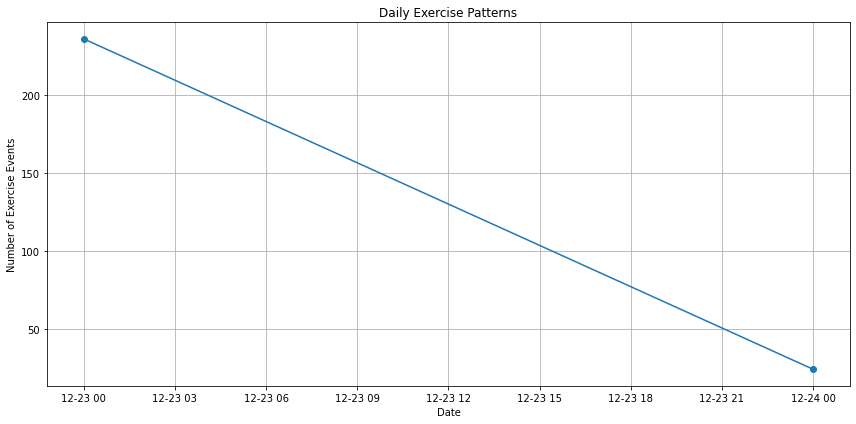

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(daily_exercise_counts.index, daily_exercise_counts.values, marker='o', linestyle='-')
plt.title('Daily Exercise Patterns')
plt.xlabel('Date')
plt.ylabel('Number of Exercise Events')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

<p>As per the above graph </p> 
<li>Given data consists of two days stepchange</li>
<li>Date of the following data set '2017-12-23' and '2017-12-24'</li>
<li>on '2017-12-23' the user step changes count is 236 and on '2017-12-24'the user step changes count is 24</li>

## Hour vs onStandStepChanged Analysis

In [21]:
analysis_over_steps = df[df['EventId'].isin(['E42'])]
analysis_over_steps['StepCount'] = analysis_over_steps['Content'].str.extract(r'onStandStepChanged (\d+)')[0].astype(float)

C:\Users\hp\AppData\Local\Temp/ipykernel_11036/1171699007.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysis_over_steps['StepCount'] = analysis_over_steps['Content'].str.extract(r'onStandStepChanged (\d+)')[0].astype(float)


In [22]:
analysis_over_steps

,LineId,Time,Component,Pid,Content,EventId,Date,Hour,Minute,Second,StepCount
0,1,2017-12-23 22:15:29.606,Step_LSC,30002312,onStandStepChanged 3579,E42,2017-12-23,22,15,29,3579.0
7,8,2017-12-23 22:15:29.636,Step_LSC,30002312,onStandStepChanged 3579,E42,2017-12-23,22,15,29,3579.0
12,13,2017-12-23 22:15:29.738,Step_LSC,30002312,onStandStepChanged 3579,E42,2017-12-23,22,15,29,3579.0
13,14,2017-12-23 22:15:29.792,Step_LSC,30002312,onStandStepChanged 3580,E42,2017-12-23,22,15,29,3580.0
20,21,2017-12-23 22:15:30.331,Step_LSC,30002312,onStandStepChanged 3581,E42,2017-12-23,22,15,30,3581.0
...,...,...,...,...,...,...,...,...,...,...,...
1923,1924,2017-12-24 00:11:57.141,Step_LSC,30002312,onStandStepChanged 3786,E42,2017-12-24,0,11,57,3786.0
1933,1934,2017-12-24 00:15:52.983,Step_LSC,30002312,onStandStepChanged 3786,E42,2017-12-24,0,15,52,3786.0
1949,1950,2017-12-24 00:25:16.137,Step_LSC,30002312,onStandStepChanged 3786,E42,2017-12-24,0,25,16,3786.0
1955,1956,2017-12-24 00:25:17.137,Step_LSC,30002312,onStandStepChanged 3786,E42,2017-12-24,0,25,17,3786.0


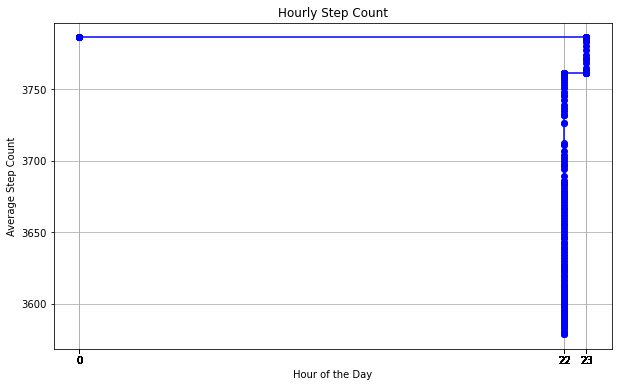

In [37]:
# Create a line plot to show the relationship between hours and step counts
plt.figure(figsize=(10, 6))
plt.plot(analysis_over_steps['Hour'],analysis_over_steps['StepCount'], marker='o', linestyle='-', color='b')
plt.title('Hourly Step Count')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Step Count')
plt.xticks(analysis_over_steps['Hour'])
plt.grid(True)

# Show the plot
plt.show()

In [52]:
numberof22= (analysis_over_steps['Hour']==22).sum()
numberof23=(analysis_over_steps['Hour']==23).sum()
numberof0= (analysis_over_steps['Hour']==0).sum()
print(numberof22)
print(numberof23)
print(numberof0)

167
69
24


<h3>As per the analysis of the above Graph</h3>
<p>For 2017-12-23 <p>
<li>The user intensively changing its steps at '22', it almost 167 time the stepscount changed</li>
<li>The user slows down the activity at '23', the total stepcount change are 69</li>
<p>For 2017-12-23</p>
<li>The total number of stepcount changed at Hour '0' is 24</li>
<p>After overall analysis, the stepchange count is decreasing, which means the user is slowing down its walking count.</p>

<h3>Anlysis the step count with hours</h3>

In [58]:
hourly_step_counts = analysis_over_steps.groupby('Hour')['StepCount'].max()

In [59]:
hourly_step_counts

Hour
0     3786.0
22    3761.0
23    3786.0
Name: StepCount, dtype: float64

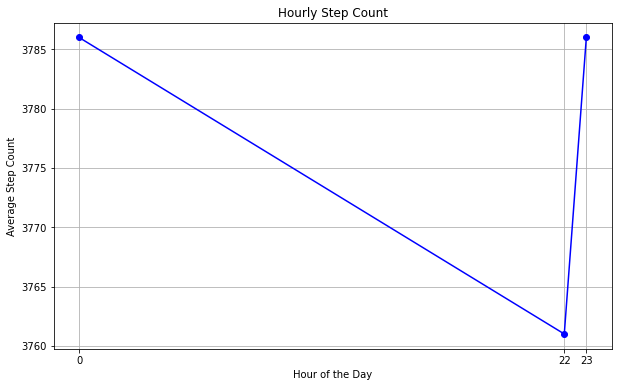

In [60]:
plt.figure(figsize=(10, 6))
plt.plot(hourly_step_counts.index, hourly_step_counts.values, marker='o', linestyle='-', color='b')
plt.title('Hourly Step Count')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Step Count')
plt.xticks(hourly_step_counts.index)
plt.grid(True)

<h3>The above graph represent the Hourly step count</h3>
<li>The data set have 3 points of hours</li>
<li>'22' and '23' represent the hours of date '2017-12-23'</li>
<li>'0' represented the Hours of date '2017-12-24'</li>
<li>At '22' the number of steps count is 3761.0</li>
<li>At '23' the number of steps count is 3786.0</li>
<li>At '0' the number of steps count is 3786.0</li>
<li>As, we can see that the onStandStepChanged is triggered at value of '0' but the number of steps are not changed</li>

## Exercise Duration

In [61]:
exercise_events = df[df['EventId'].isin(['E42'])]
exercise_events['Duration'] = exercise_events.groupby(['Pid', 'EventId'])['Time'].diff()

# Drop rows with missing durations (e.g., missing 'onExtend' events)
exercise_events = exercise_events.dropna(subset=['Duration'])

C:\Users\hp\AppData\Local\Temp/ipykernel_11036/1960470082.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exercise_events['Duration'] = exercise_events.groupby(['Pid', 'EventId'])['Time'].diff()


In [70]:
exercise_events.head(2)

,LineId,Time,Component,Pid,Content,EventId,Date,Hour,Minute,Second,Duration,DurationSeconds,StepCount
7,8,2017-12-23 22:15:29.636,Step_LSC,30002312,onStandStepChanged 3579,E42,2017-12-23,22,15,29,0 days 00:00:00.030000,0.030,3579.0
12,13,2017-12-23 22:15:29.738,Step_LSC,30002312,onStandStepChanged 3579,E42,2017-12-23,22,15,29,0 days 00:00:00.102000,0.102,3579.0


In [67]:
exercise_events = exercise_events.dropna(subset=['Duration'])

# Convert duration to seconds
exercise_events['DurationSeconds'] = exercise_events['Duration'].dt.total_seconds()

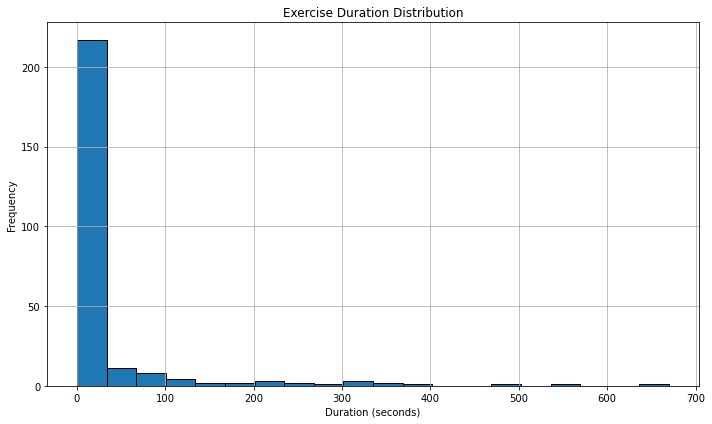

In [69]:
plt.figure(figsize=(10, 6))
plt.hist(exercise_events['DurationSeconds'], bins=20, edgecolor='black')
plt.title('Exercise Duration Distribution')
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

<p>The above graph represent the frequency of EVENTID E42 with the time duration starts from zero</p>
<li>This graph show the intensity of the E42 eventid is high in the beggining of the dataset till the 100 duration(in seconds)</li>

## Analysing Days and their steps

In [30]:
# Group exercise events by date and count the number of events per day
activity_per_day = exercise_events.groupby(exercise_events['Time'].dt.date).size()

# Sort the days by activity count in descending order
activity_per_day = activity_per_day.sort_values(ascending=False)

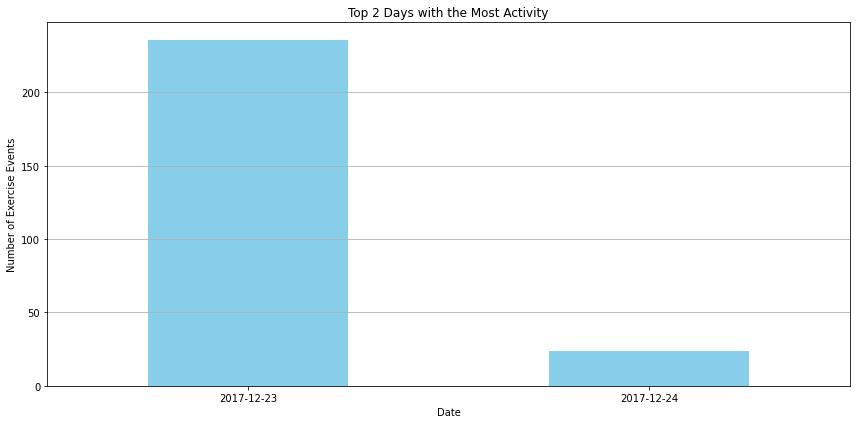

In [32]:
top_n_days = 2  # Change this to display a different number of days
plt.figure(figsize=(12, 6))
activity_per_day.head(top_n_days).plot(kind='bar', color='skyblue')
plt.title(f'Top {top_n_days} Days with the Most Activity')
plt.xlabel('Date')
plt.ylabel('Number of Exercise Events')
plt.xticks(rotation=0)
plt.grid(axis='y')

# Show the plot
plt.tight_layout()
plt.show()

<h3>The above graph represent the Event analysis with 2 days</h3>
<li>The number of Event on 2017-12-23 is 250+ </li>
<li>The number of event on 2017-12-24 is around 30</li>
<li>2017-12-23 has more number of event as compare to 2017-12-24</li>

## Number of events and their frequency 

In [33]:
event_type_counts = df['EventId'].value_counts()

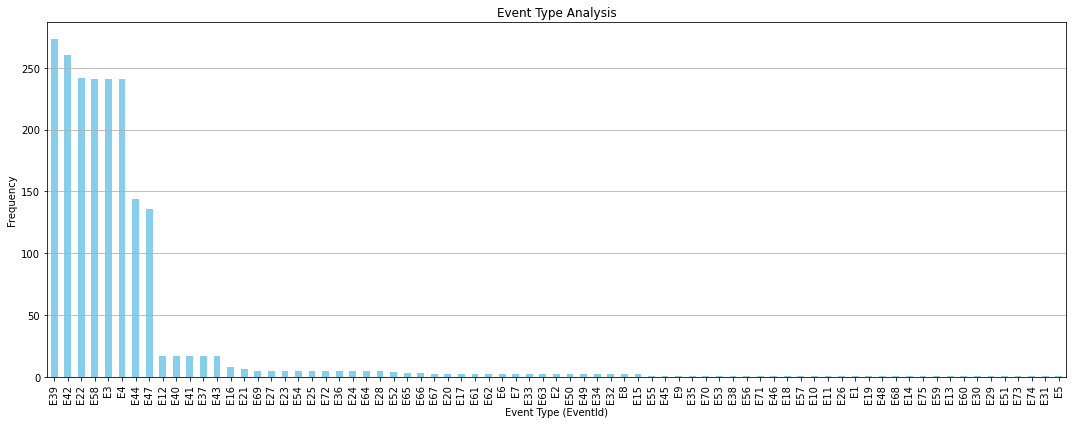

In [34]:
plt.figure(figsize=(15, 6))
event_type_counts.plot(kind='bar', color='skyblue')
plt.title('Event Type Analysis')
plt.xlabel('Event Type (EventId)')
plt.ylabel('Frequency')
# plt.xticks(rotation=45)
plt.grid(axis='y')

# Show the plot
plt.tight_layout()
plt.show()

<h3>The above graph represent the Event Type Analysis</h3>
<li>EventId E39 (onExtend) have the highest occurance in the dataset, it is around 250+ times trigger in the dataset</li>
<li>The EventId E22(getTodayTotalDetailSteps),E58(setTodayTotalDetailSteps),E3(calculateAltitudeWithCache totalAltitude),E4(calculateCaloriesWithCache totalCalories) have same number of occurance in the dataset</li>
<li>E44 and E47 have the same number of occurance </li>
<li>E12, E40,E41,E37 and E43 have occurance around 10 times</li>

<h2>Analysis on calculateCaloriesWithCache totalCalories Event ID E4</h2>

In [83]:
CaloriesWithCache_df = df[df['EventId'] == 'E4'][['Hour', 'EventId','Content']]
CaloriesWithCache_df['totalCalories'] = CaloriesWithCache_df['Content'].str.extract(r'totalCalories=(\d+)')[0].astype(float)

In [109]:
CaloriesWithCache_df['totalCalories'].max()

131208.0

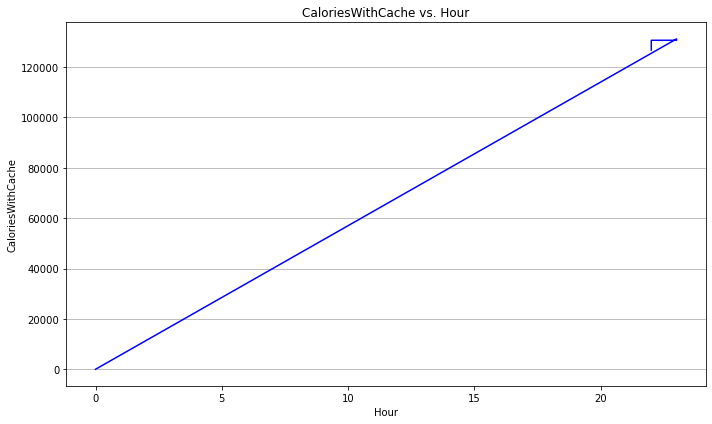

In [97]:
plt.figure(figsize=(10, 6))
plt.plot(CaloriesWithCache_df['Hour'], CaloriesWithCache_df['totalCalories'], color='blue')
plt.xlabel('Hour')
plt.ylabel('CaloriesWithCache')
plt.title('CaloriesWithCache vs. Hour')

# Show the plot
plt.grid(axis='y')
plt.tight_layout()
plt.show()

<p>As per the analysis of the above bar graph the most of the calories count are occured at the time of '22' and '23'</p>
<li>Maximum calories of the dataset is 131208</li>

<h2>Analysis on calculateAltitudeWithCache totalAltitude</h2>

In [93]:
totalAltitude_df = df[df['EventId'] == 'E3'][['Hour', 'EventId','Content']]
totalAltitude_df['totalAltitude'] = totalAltitude_df['Content'].str.extract(r'totalAltitude=(\d+)')[0].astype(float)

In [108]:
totalAltitude_df['totalAltitude'].unique()

array([240.,   0.])

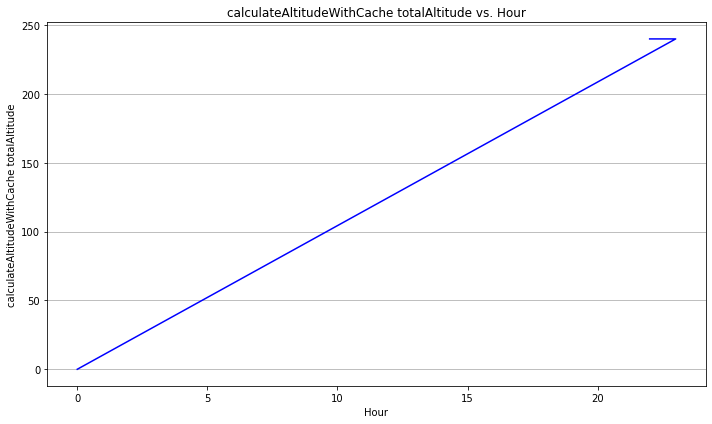

In [98]:
plt.figure(figsize=(10, 6))
plt.plot(totalAltitude_df['Hour'], totalAltitude_df['totalAltitude'], color='blue')
plt.xlabel('Hour')
plt.ylabel('calculateAltitudeWithCache totalAltitude')
plt.title('calculateAltitudeWithCache totalAltitude vs. Hour')

# Show the plot
plt.grid(axis='y')
plt.tight_layout()
plt.show()

This graph is also showing the high intensity at 22 and 23 which is equal to 240  

## Timeline

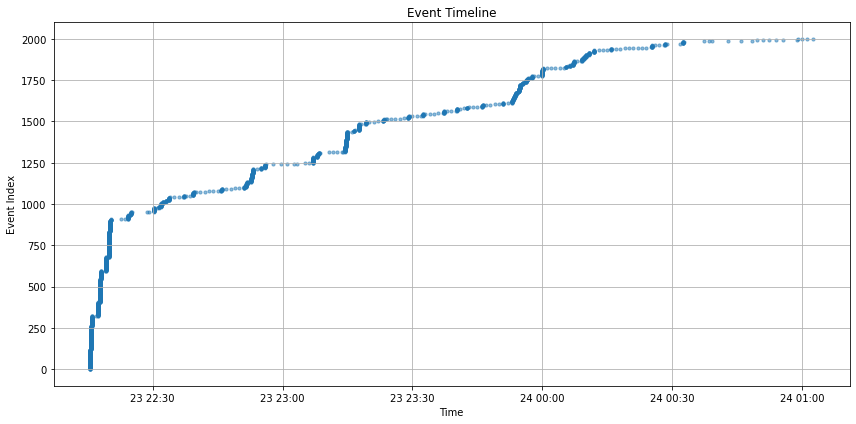

In [35]:
# Create a scatter plot to visualize event occurrences over time
plt.figure(figsize=(12, 6))
plt.scatter(df['Time'], df.index, marker='o', s=10, alpha=0.5)
plt.title('Event Timeline')
plt.xlabel('Time')
plt.ylabel('Event Index')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

<p>The Event timeline expressed the scatter plot with high intensity before 23 22:30 </p>

## Frequency of steps count along with Hours

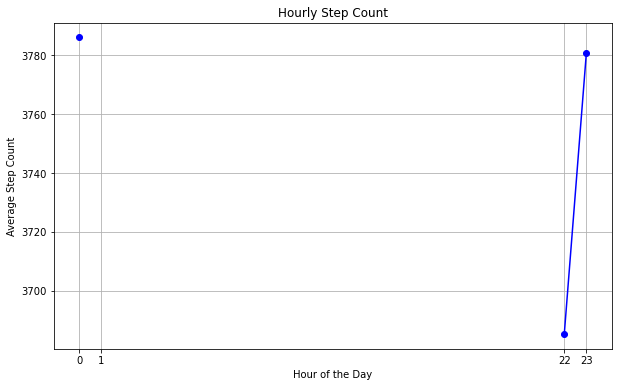

In [36]:
hourly_step_counts = df.groupby('Hour')['StepCount'].mean()

# Create a line plot to show the relationship between hours and step counts
plt.figure(figsize=(10, 6))
plt.plot(hourly_step_counts.index, hourly_step_counts.values, marker='o', linestyle='-', color='b')
plt.title('Hourly Step Count')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Step Count')
plt.xticks(hourly_step_counts.index)
plt.grid(True)

# Show the plot
plt.show()

## week day and weekend activity

C:\Users\hp\AppData\Local\Temp/ipykernel_16948/3032738024.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exercise_events['DayOfWeek'] = exercise_events['Time'].dt.dayofweek


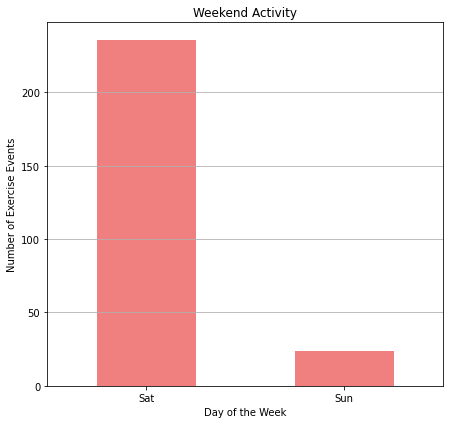

In [37]:
if not exercise_events.empty:
    # Extract day of the week (0=Monday, 6=Sunday)
    exercise_events['DayOfWeek'] = exercise_events['Time'].dt.dayofweek

    # Separate exercise events into two DataFrames: one for weekdays (Monday to Friday) and another for weekends (Saturday and Sunday)
    weekday_activity = exercise_events[exercise_events['DayOfWeek'] < 5]
    weekend_activity = exercise_events[exercise_events['DayOfWeek'] >= 5]

    # Create bar charts to visualize weekday vs. weekend activity
    plt.figure(figsize=(12, 6))

    if not weekday_activity.empty:
        plt.subplot(1, 2, 1)
        weekday_activity_counts = weekday_activity['DayOfWeek'].value_counts().sort_index()
        weekday_activity_counts.plot(kind='bar', color='skyblue')
        plt.title('Weekday Activity')
        plt.xlabel('Day of the Week')
        plt.ylabel('Number of Exercise Events')
        plt.xticks(range(5), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri'], rotation=0)
        plt.grid(axis='y')

    if not weekend_activity.empty:
        plt.subplot(1, 2, 2)
        weekend_activity_counts = weekend_activity['DayOfWeek'].value_counts().sort_index()
        weekend_activity_counts.plot(kind='bar', color='lightcoral')
        plt.title('Weekend Activity')
        plt.xlabel('Day of the Week')
        plt.ylabel('Number of Exercise Events')
        plt.xticks(range(2), ['Sat', 'Sun'], rotation=0)
        plt.grid(axis='y')

    plt.tight_layout()
    plt.show()
else:
    print("No exercise events found in the log data.")

The Above graph is representing the number of events occured on weekdays and weekends
<li>The weekend activity bar graph is clearly shows that the data is represent the weekend day</li>

## Anomaly Detection

In [99]:
df['StepCount'] = exercise_events['Content'].str.extract(r'onStandStepChanged (\d+)')[0].astype(float)
df['totalAltitude'] = exercise_events['Content'].str.extract(r'totalAltitude=(\d+)')[0].astype(float)
df['totalCalories'] = exercise_events['Content'].str.extract(r'totalCalories=(\d+)')[0].astype(float)
# Calculate the Z-score for the 'StepCount' column
mean_step_count = df['StepCount'].mean()
std_step_count = df['StepCount'].std()
z_scores = np.abs((df['StepCount'] - mean_step_count) / std_step_count)

In [100]:
# Set a threshold for anomaly detection
threshold = 3  # Z-score threshold for anomalies

# Find and mark anomalies
anomalies = df[z_scores > threshold]
df['IsAnomaly'] = False
df.loc[anomalies.index, 'IsAnomaly'] = True

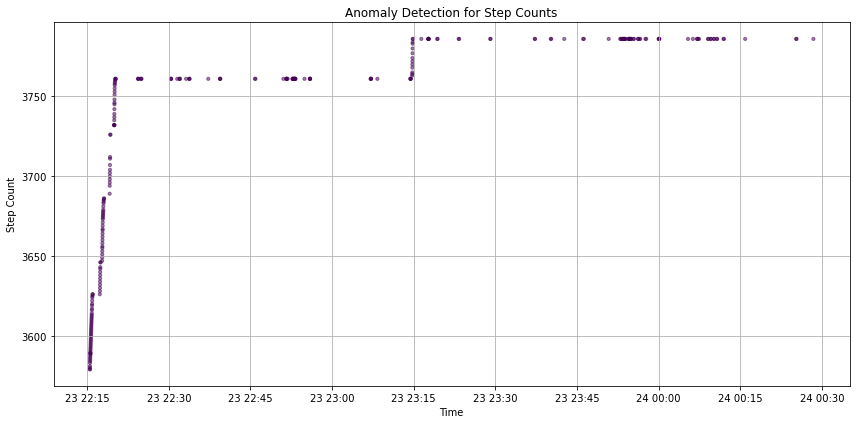

In [101]:
plt.figure(figsize=(12, 6))
plt.scatter(df['Time'], df['StepCount'], marker='o', s=10, alpha=0.5, c=df['IsAnomaly'], cmap='viridis')
plt.title('Anomaly Detection for Step Counts')
plt.xlabel('Time')
plt.ylabel('Step Count')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

## Analysis over content data

In [102]:
text_data = df['Content']

# Combine all text entries into a single string
combined_text = ' '.join(text_data)

# Tokenize the text using NLTK
nltk.download('punkt')
tokens = word_tokenize(combined_text)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [103]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
filtered_tokens = [word for word in tokens if word.lower() not in stop_words]

# Create a frequency distribution of words
word_freq = Counter(filtered_tokens)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [104]:
most_common_words = word_freq.most_common(10)
print("Most Common Words:")
for word, freq in most_common_words:
    print(f"{word}: {freq}")

Most Common Words:
#: 4842
0: 566
8661: 483
16256: 400
:: 334
=: 307
onStandStepChanged: 260
549659: 256
getTodayTotalDetailSteps: 242
calculateCaloriesWithCache: 241


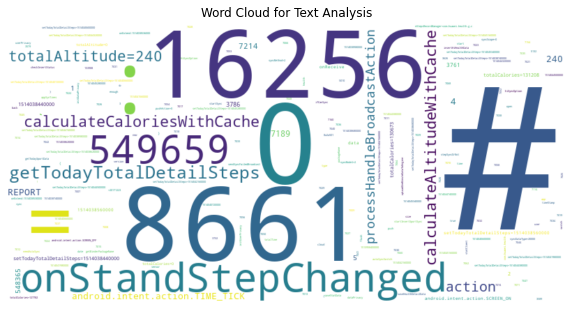

In [105]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Text Analysis')
plt.axis('off')
plt.show()

## Correlation matrix for df Dataframe

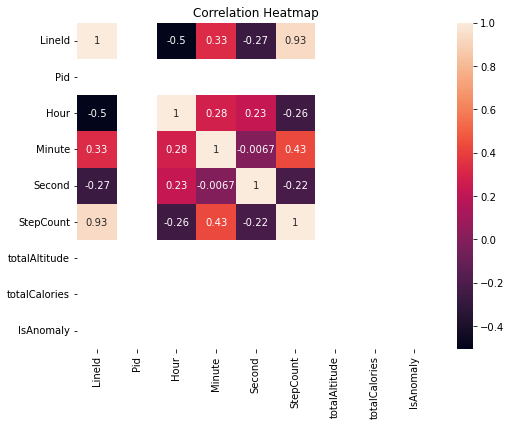

In [106]:
correlation_matrix = df.corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True)
plt.title('Correlation Heatmap')
plt.show()

No above heatmap represent the relation between time, not representing any thing specific 

<h2>Results</h2>
<li>Given data consists of two days stepchange</li>
<li>Date of the following data set '2017-12-23' and '2017-12-24'</li>
<li>on '2017-12-23' the user step changes count is 236 and on '2017-12-24'the user step changes count is 24</li>
<p>For 2017-12-23 <p>
<li>The user intensively changing its steps at '22', it almost 167 time the stepscount changed</li>
<li>The user slows down the activity at '23', the total stepcount change are 69</li>
<p>For 2017-12-23</p>
<li>The total number of stepcount changed at Hour '0' is 24</li>
<p>After overall analysis, the stepchange count is decreasing, which means the user is slowing down its walking count.</p>
<li>The data set have 3 points of hours</li>
<li>'22' and '23' represent the hours of date '2017-12-23'</li>
<li>'0' represented the Hours of date '2017-12-24'</li>
<li>At '22' the number of steps count is 3761.0</li>
<li>At '23' the number of steps count is 3786.0</li>
<li>At '0' the number of steps count is 3786.0</li>
<li>As, we can see that the onStandStepChanged is triggered at value of '0' but the number of steps are not changed</li>
<li>show the intensity of the E42 eventid is high in the beggining of the dataset till the 100 duration(in seconds)</li>
<li>The number of Event on 2017-12-23 is 250+ </li>
<li>The number of event on 2017-12-24 is around 30</li>
<li>2017-12-23 has more number of event as compare to 2017-12-24</li>
<li>EventId E39 (onExtend) have the highest occurance in the dataset, it is around 250+ times trigger in the dataset</li>
<li>The EventId E22(getTodayTotalDetailSteps),E58(setTodayTotalDetailSteps),E3(calculateAltitudeWithCache totalAltitude),E4(calculateCaloriesWithCache totalCalories) have same number of occurance in the dataset</li>
<li>E44 and E47 have the same number of occurance </li>
<li>E12, E40,E41,E37 and E43 have occurance around 10 times</li>
<li>Maximum calories of the dataset is 131208</li>
<li>calculateAltitudeWithCache totalAltitude showing the high intensity at 22 and 23 which is equal to 240</li>
<li>The weekend activity bar graph is clearly shows that the data is represent the weekend day which is on saturday and sunday</li>